In [1]:
import numpy as np

import seaborn as sns
import torch

In [2]:
data = np.load('MLPopulation/data/Combined_GWTC_m1m2chieffz.npz')

In [3]:
m1 = data['m1']

In [4]:
m1 = torch.from_numpy(m1)

In [5]:
def softplus_inv(y):
    return y + y.neg().expm1().neg().log()


In [6]:
logm1 = softplus_inv(m1)
mu = logm1.mean()
std = logm1.std()
logm1 = (logm1 - mu) / std

<AxesSubplot:ylabel='Density'>

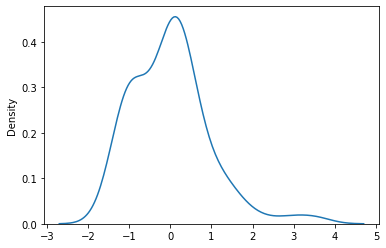

In [7]:
sns.kdeplot(logm1.mean(-1))

In [8]:
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [9]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)


In [10]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])



In [11]:
steps = 1
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))



step: 0, loss: 5.251041889190674


In [12]:
dataset = torch.tensor(logm1, dtype=torch.float)

/var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/ipykernel_8056/33368643.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(logm1, dtype=torch.float)


In [13]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
# spline_transform = T.spline_coupling(1, count_bins=8)
# spline_transform = T.spline(1, count_bins=8)
spline_transform = T.spline_autoregressive(1, count_bins=8)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])




/Users/druhe/Projects/gw/.venv/lib/python3.9/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [14]:
import math
import matplotlib.pyplot as plt

step: 0, loss: 1.3279446363449097


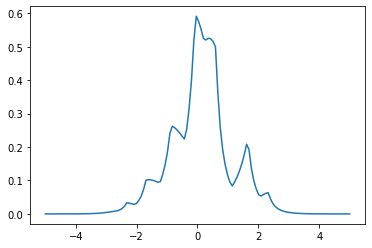

step: 1, loss: 1.3133559226989746


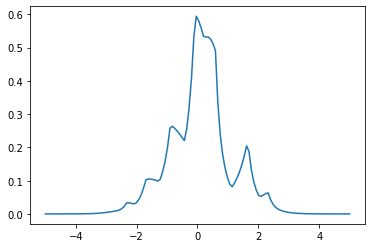

In [15]:
steps = 1
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    log_prob = flow_dist.log_prob(dataset.view(-1, 1)).view(dataset.shape)
    
    log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 1 == 0:
        with torch.no_grad():
            print('step: {}, loss: {}'.format(step, loss.item()))
            X = torch.linspace(-5, 5, 128)
            p = flow_dist.log_prob(X[:, None]).exp()
            plt.plot(X.numpy(), p.numpy())
            plt.show()




In [16]:
z = flow_dist.sample((1024,))

In [17]:
z = (z * std) + mu

In [18]:
z = torch.nn.functional.softplus(z)

<AxesSubplot:ylabel='Density'>

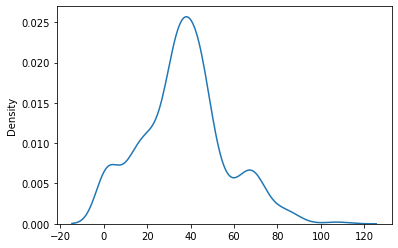

In [19]:
sns.kdeplot(z.squeeze())

In [20]:
data = np.load('MLPopulation/data/Combined_GWTC_m1m2chieffz.npz')

In [21]:
m1 = torch.from_numpy(data['m1'])
m2 = torch.from_numpy(data['m2'])

# randindex = torch.randint(0, 30000, (30000,))
# m1 = m1[:, randindex]
# m2 = m2[:, randindex]

dim = 2
X = torch.stack([m1, m2], dim=-1)

In [22]:
X = softplus_inv(X)
# X = X.log()

In [23]:
mu = torch.mean(X.view(-1, dim), dim=0, keepdim=True)
std = torch.std(X.view(-1, dim), dim=0, keepdim=True)

In [24]:
X = (X - mu) / std
dataset = X.float()

In [25]:
X_val = X[-10:].float()
X = X[:-10].float()

In [26]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform_1 = T.spline_autoregressive(dim, count_bins=8)
# spline_transform_2 = T.spline_autoregressive(dim, count_bins=8)
spline_transform_2 = T.affine_autoregressive(dim)
spline_transform = T.ComposeTransformModule([spline_transform_1, spline_transform_2])
flow_dist = dist.TransformedDistribution(base_dist, spline_transform)





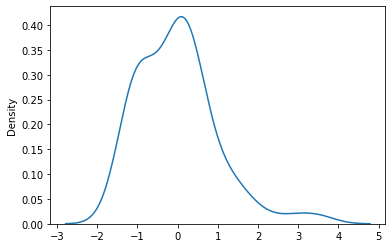

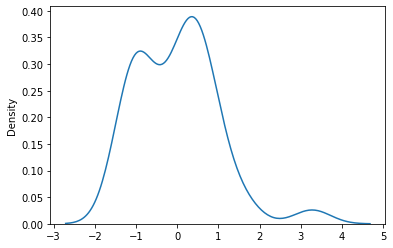

In [27]:
for i in range(X.shape[-1]):
    sns.kdeplot(X[:, :, i].mean(-1))
    plt.show()

In [28]:
# steps = 5000
# optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
# for step in range(steps+1):
#     optimizer.zero_grad()
#     log_prob = flow_dist.log_prob(dataset.view(-1, dim)).view(dataset.shape[:-1])
    
#     log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
#     loss = -log_prob.mean()
#     loss.backward()
#     optimizer.step()
#     flow_dist.clear_cache()

#     if step % 1 == 0:
#         print('step: {}, loss: {}'.format(step, loss.item()))


#         with torch.no_grad():
#             if dim == 1:
#                 X = torch.linspace(-5, 5, 128)
#                 p = flow_dist.log_prob(X[:, None]).exp()
#                 plt.plot(X.numpy(), p.numpy())
#                 plt.show()
#             else:
#                 linspace = torch.linspace(-5, 5, 128)
#                 grid = torch.meshgrid(linspace, linspace, indexing='xy')
#                 grid = torch.stack(grid).view(2, -1).permute(1, 0)
#                 p = flow_dist.log_prob(grid).exp().view(128, 128)
#                 plt.plot(linspace.numpy(), p.sum(0).numpy())
#                 plt.show()
                
#                 plt.plot(linspace.numpy(), p.sum(1).numpy())
#                 plt.show()
                







In [29]:
from torch import nn

In [30]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform_1 = T.spline_autoregressive(dim, count_bins=8)

spline_transform_2 = T.spline_autoregressive(dim, count_bins=8)
# spline_transform_2 = T.affine_autoregressive(dim)
spline_transform = T.ComposeTransformModule([spline_transform_1])

transform = []
for t in range(2):
    transform.append(T.spline_autoregressive(dim))
    transform.append(T.permute(dim, torch.tensor((1, 0))))
    
    
    
transform = []
transform.append(T.spline_autoregressive(dim))
transform.append(T.permute(dim, torch.tensor((1, 0))))


# transform.append(T.permute(dim, torch.tensor([(1, 0)])))
transform.append(T.affine_autoregressive(dim))
# spline_transform = T.ComposeTransformModule(transform)


flow_dist = dist.TransformedDistribution(base_dist, transform)

trainable_parameters = nn.ModuleList([t for t in transform if isinstance(t, nn.Module)])




step: 0, loss: 2.652738571166992


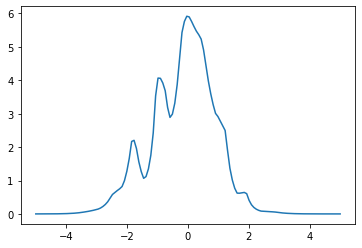

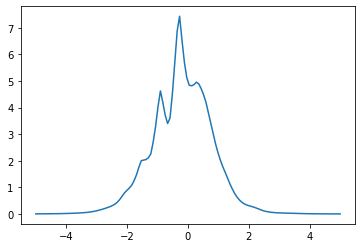

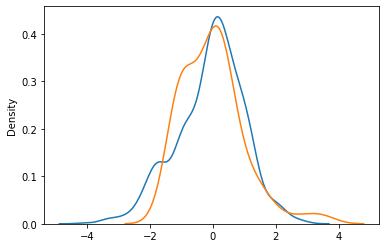

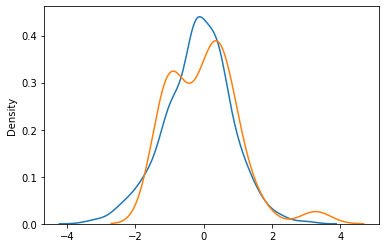

val loss 2.652738571166992
step: 1, loss: 2.5513572692871094


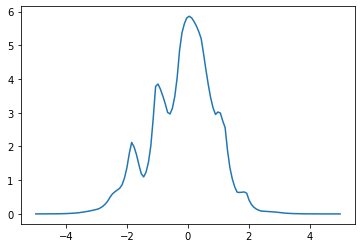

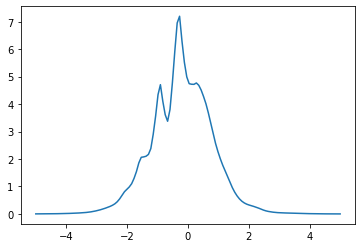

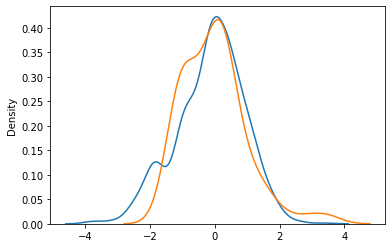

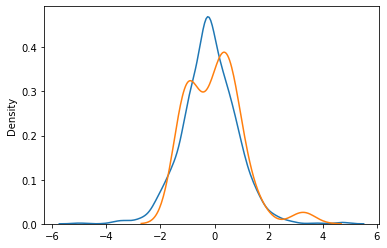

val loss 2.5513572692871094
step: 2, loss: 2.4804940223693848


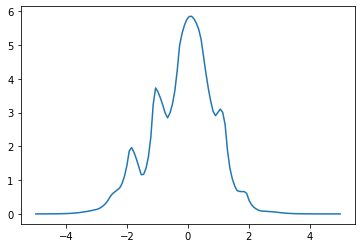

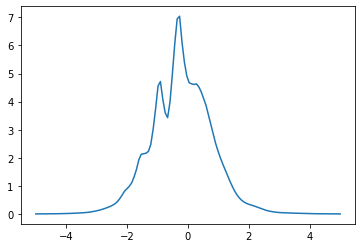

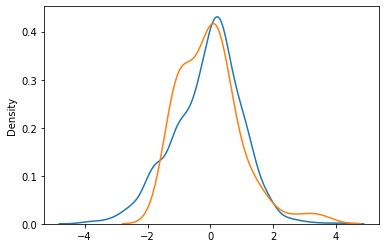

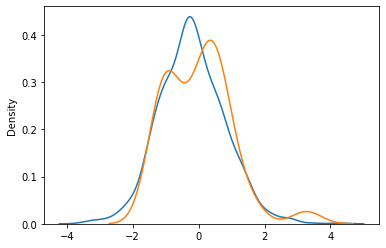

val loss 2.4804940223693848
step: 3, loss: 2.430475950241089


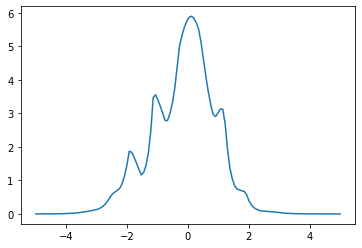

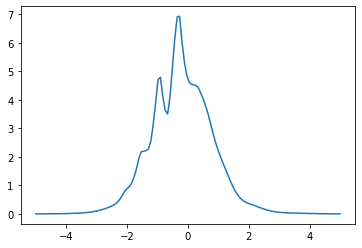

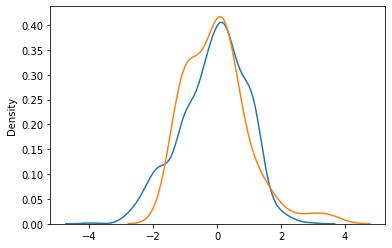

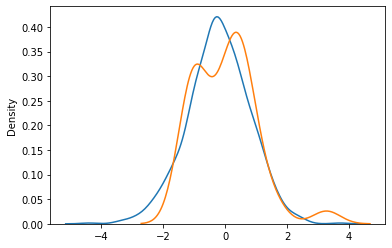

val loss 2.430475950241089
step: 4, loss: 2.3898491859436035


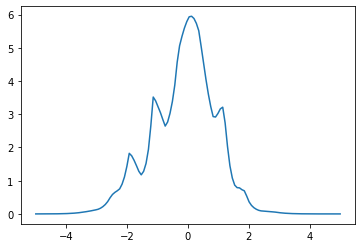

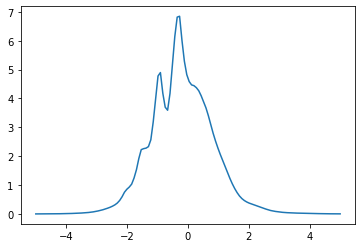

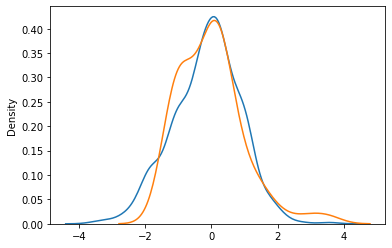

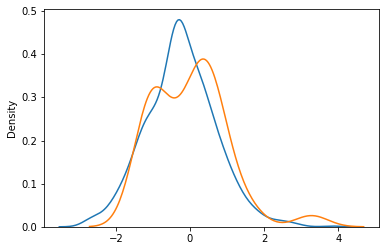

val loss 2.3898491859436035
step: 5, loss: 2.351886749267578


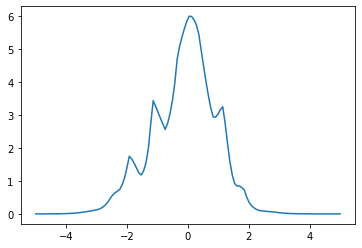

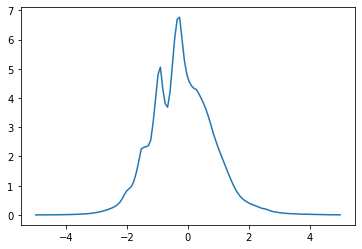

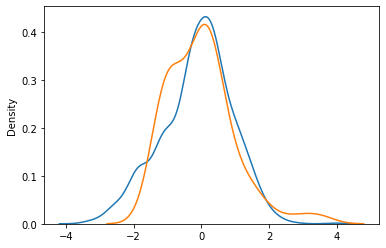

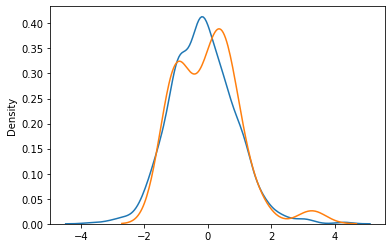

val loss 2.351886749267578
step: 6, loss: 2.3151633739471436


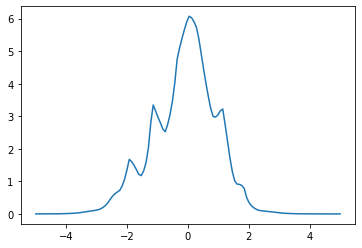

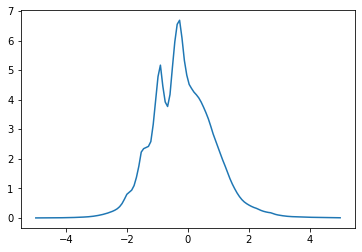

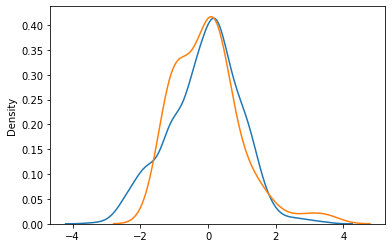

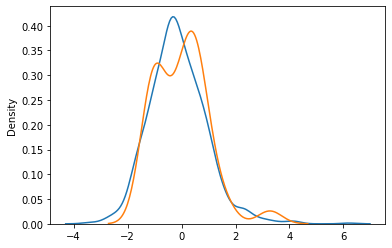

val loss 2.3151633739471436
step: 7, loss: 2.2800304889678955


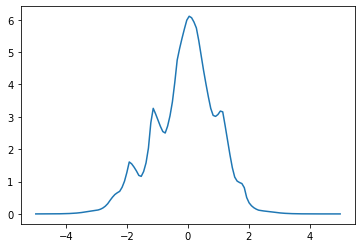

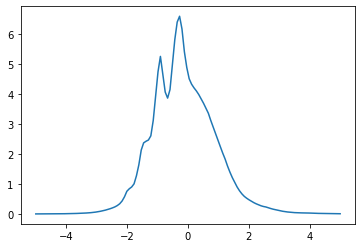

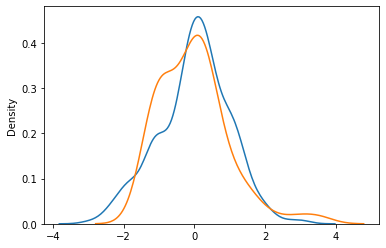

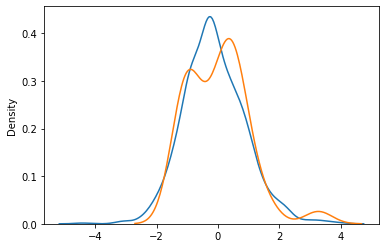

val loss 2.2800304889678955
step: 8, loss: 2.2468936443328857


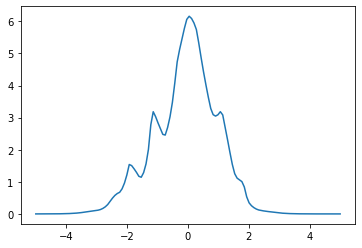

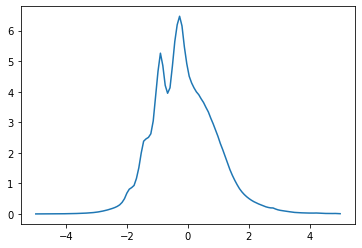

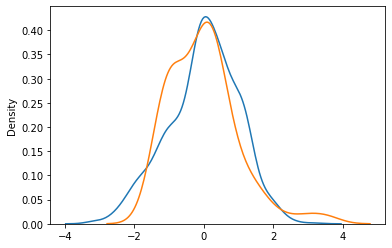

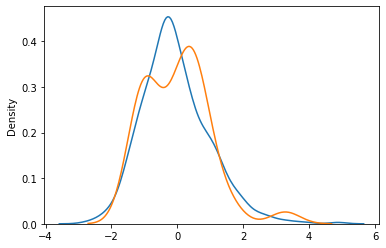

val loss 2.2468936443328857
step: 9, loss: 2.214742660522461


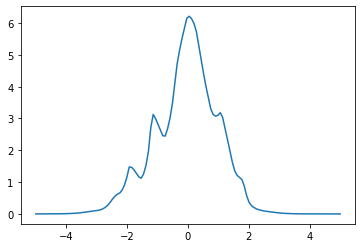

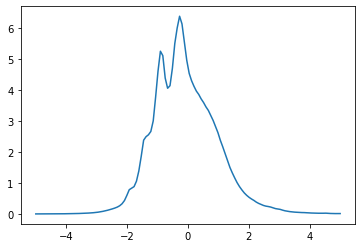

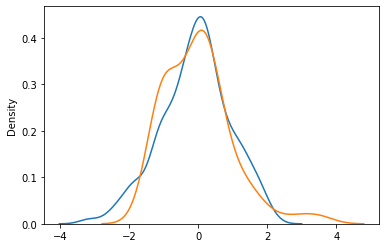

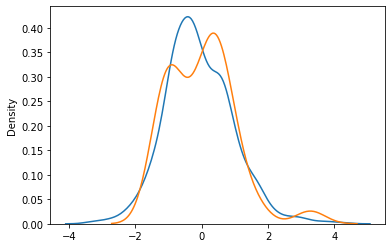

val loss 2.214742660522461
step: 10, loss: 2.1836180686950684


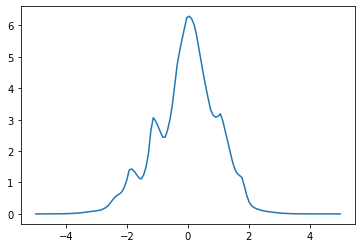

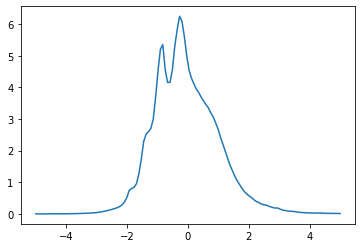

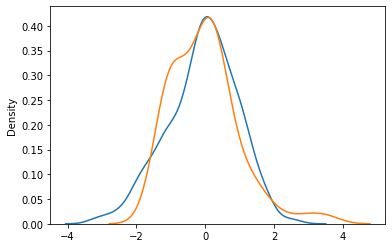

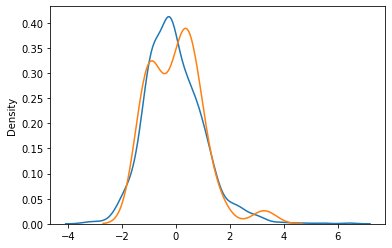

val loss 2.1836180686950684
step: 11, loss: 2.1536197662353516


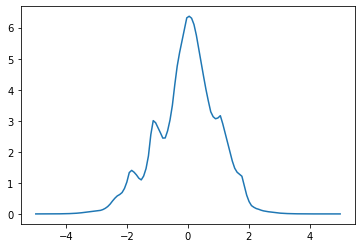

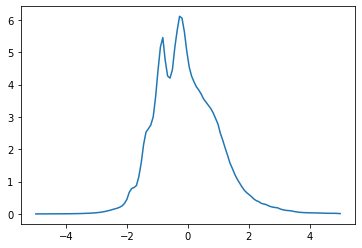

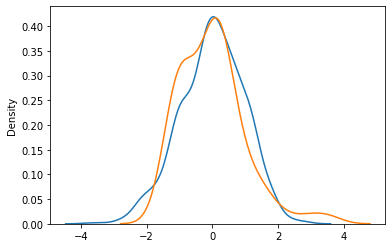

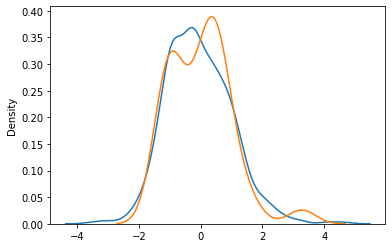

val loss 2.1536197662353516
step: 12, loss: 2.1240053176879883


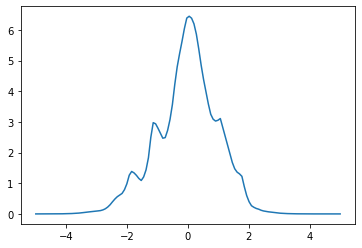

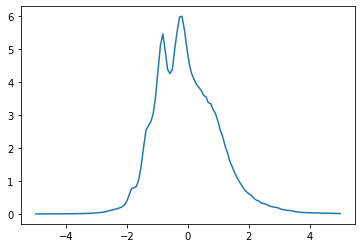

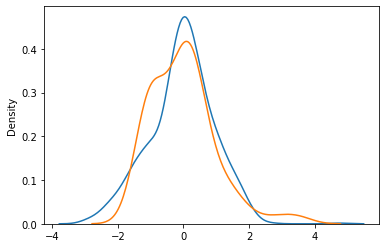

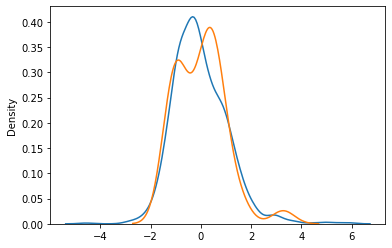

val loss 2.1240053176879883
step: 13, loss: 2.093374013900757


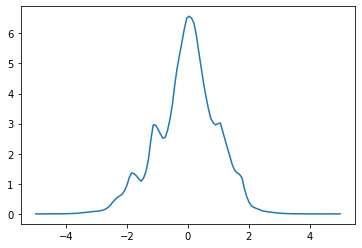

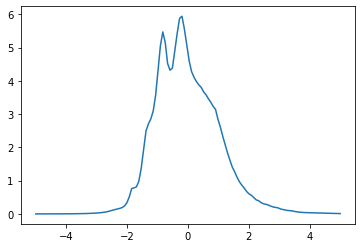

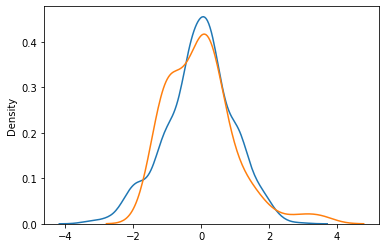

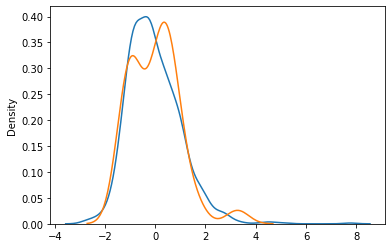

val loss 2.093374013900757
step: 14, loss: 2.0631420612335205


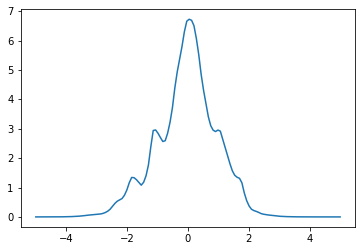

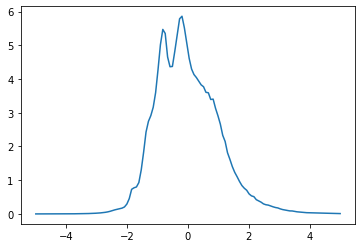

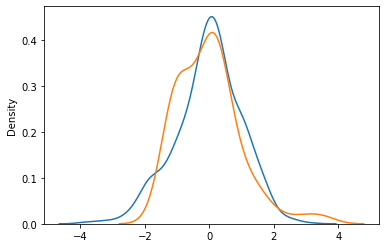

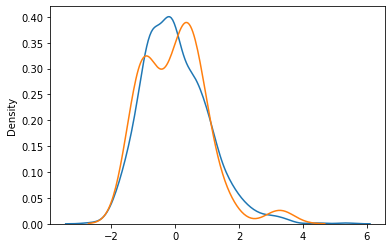

val loss 2.0631420612335205
step: 15, loss: 2.0345168113708496


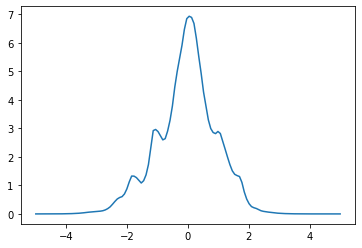

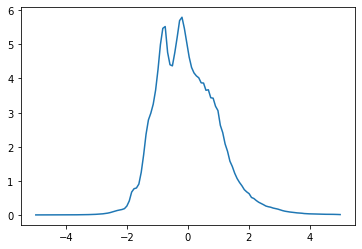

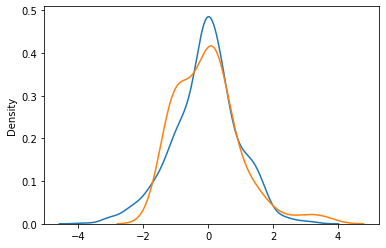

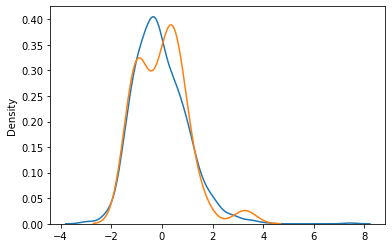

val loss 2.0345168113708496
step: 16, loss: 2.0067288875579834


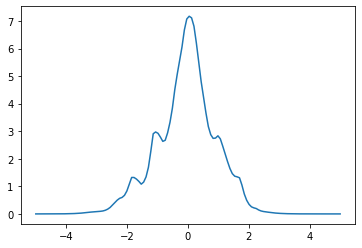

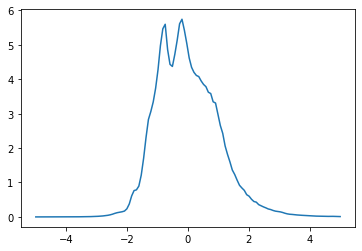

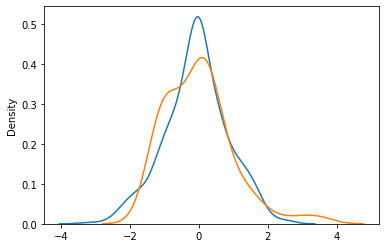

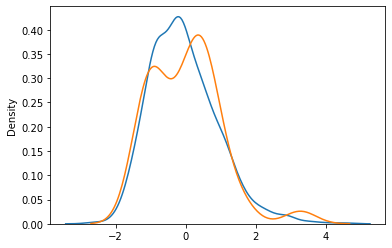

val loss 2.0067288875579834
step: 17, loss: 1.9793165922164917


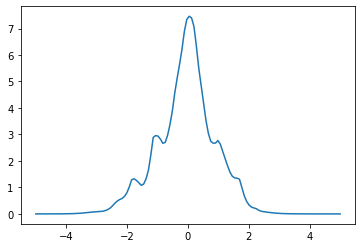

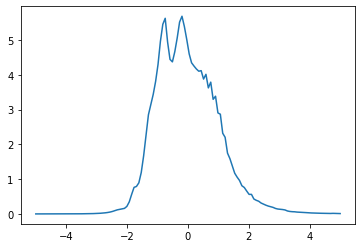

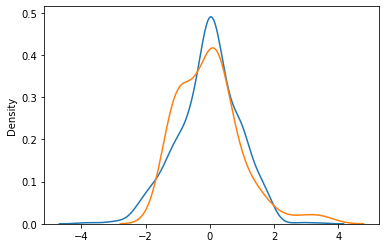

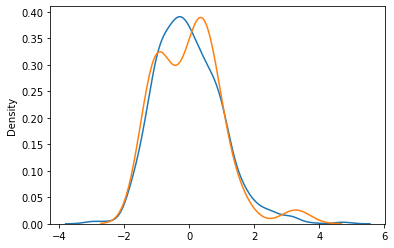

val loss 1.9793165922164917
step: 18, loss: 1.9526749849319458


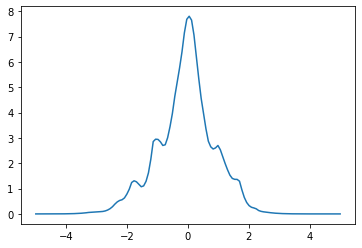

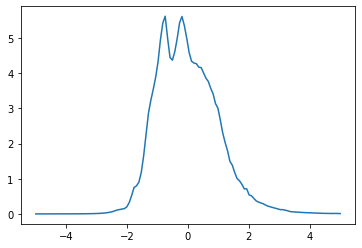

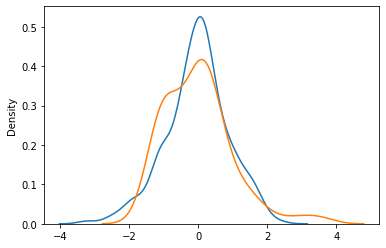

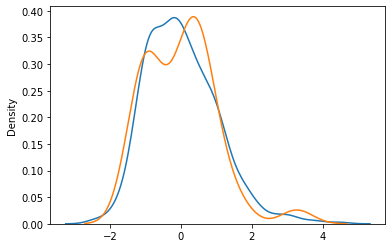

val loss 1.9526749849319458
step: 19, loss: 1.926484227180481


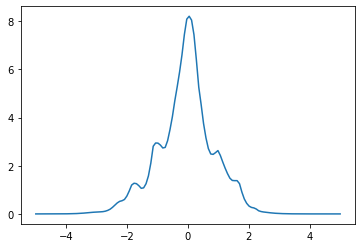

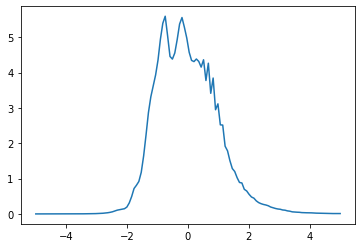

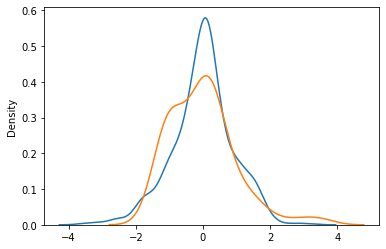

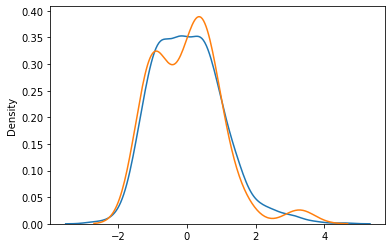

val loss 1.926484227180481
step: 20, loss: 1.9010063409805298


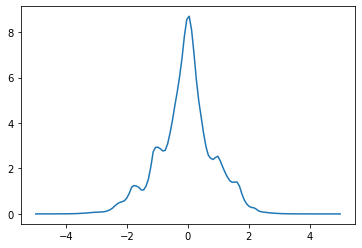

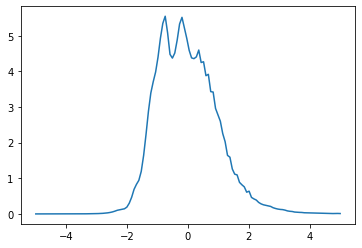

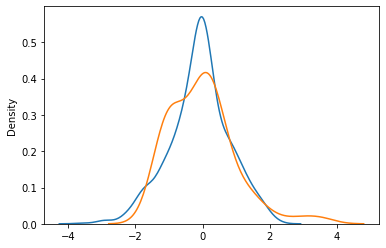

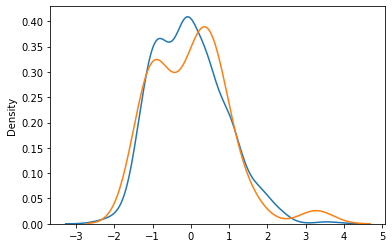

val loss 1.9010063409805298
step: 21, loss: 1.876738429069519


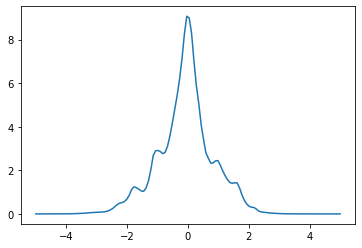

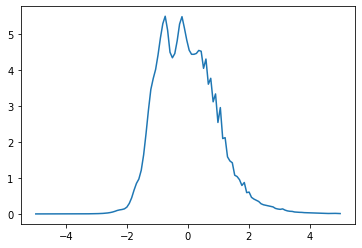

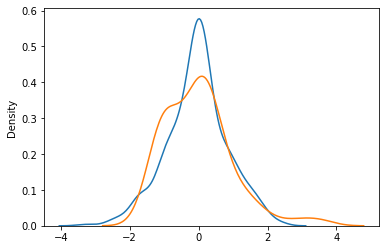

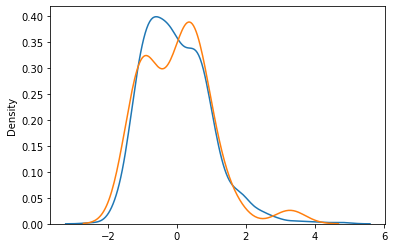

val loss 1.876738429069519
step: 22, loss: 1.8533729314804077


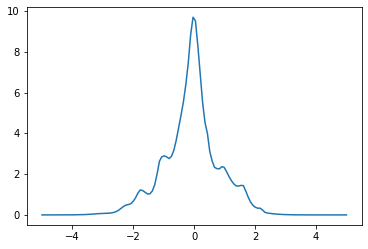

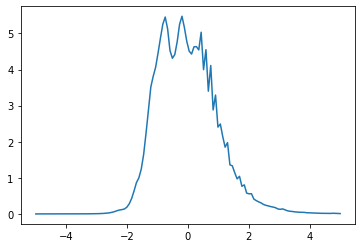

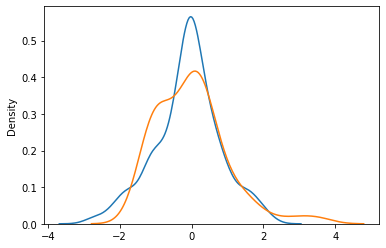

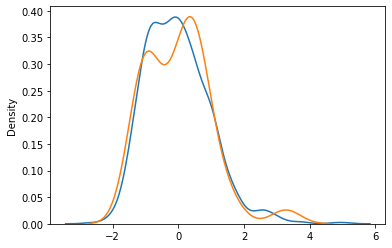

val loss 1.8533729314804077
step: 23, loss: 1.8305858373641968


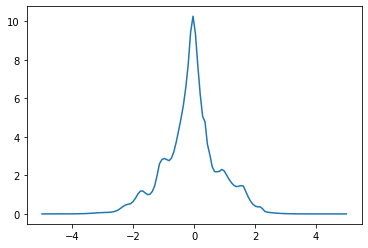

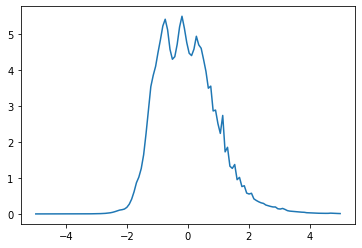

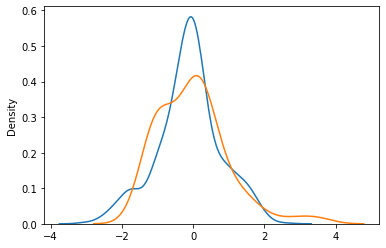

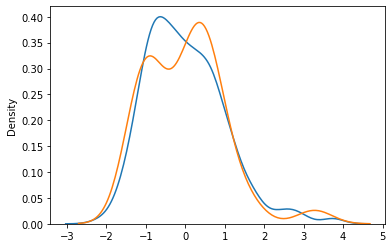

val loss 1.8305858373641968
step: 24, loss: 1.8098547458648682


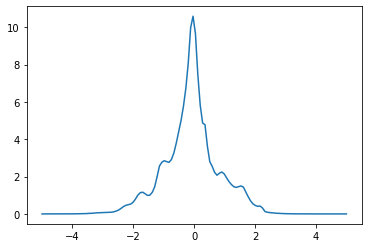

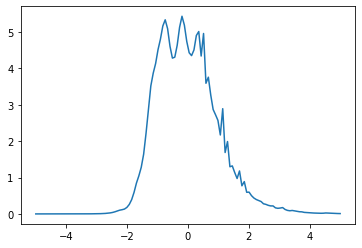

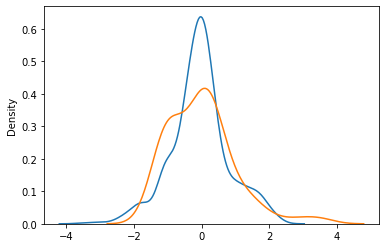

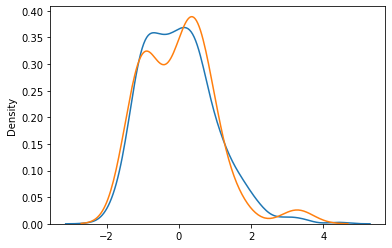

val loss 1.8098547458648682
step: 25, loss: 1.7883683443069458


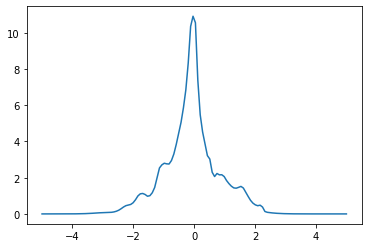

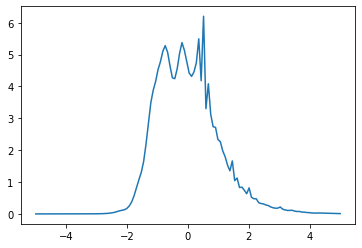

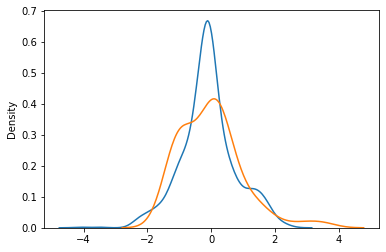

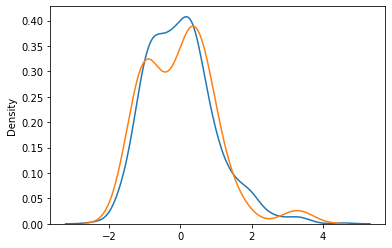

val loss 1.7883683443069458
step: 26, loss: 1.766645073890686


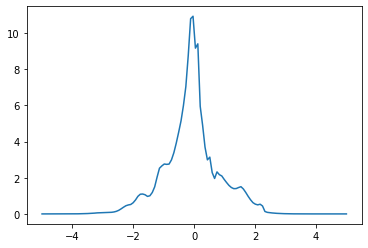

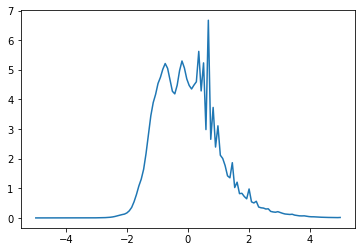

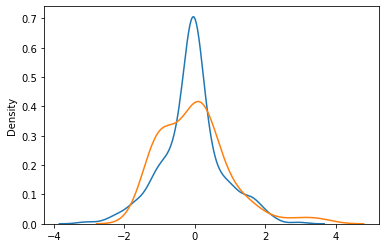

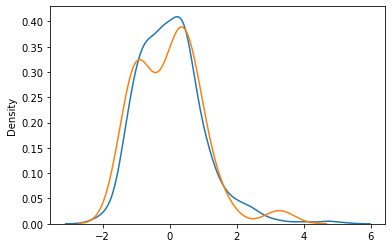

val loss 1.766645073890686
step: 27, loss: 1.7446773052215576


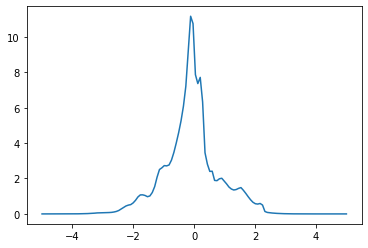

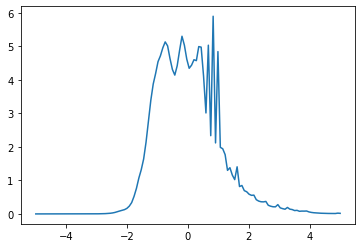

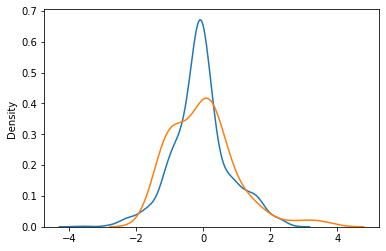

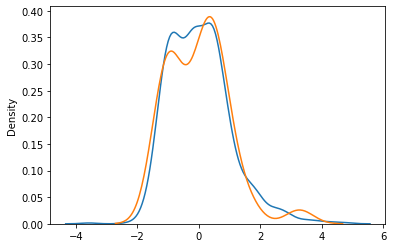

val loss 1.7446773052215576
step: 28, loss: 1.7228186130523682


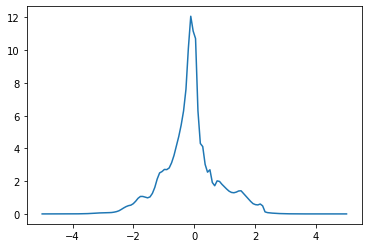

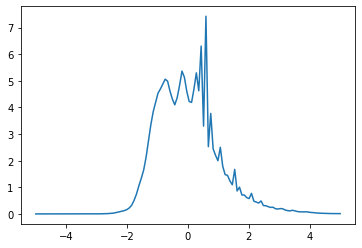

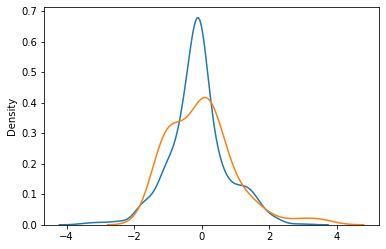

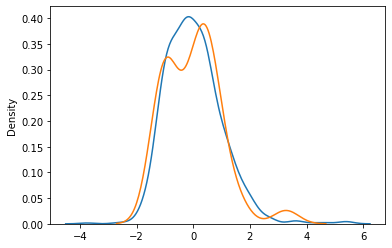

val loss 1.7228186130523682
step: 29, loss: 1.7078436613082886


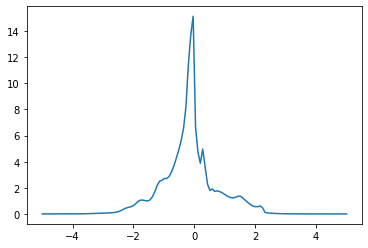

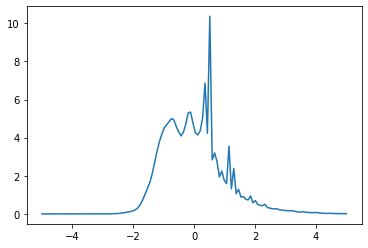

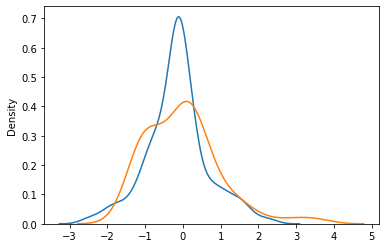

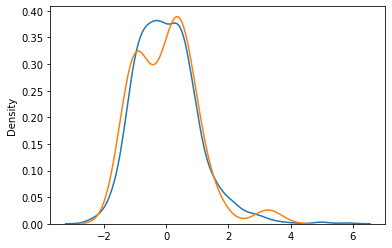

val loss 1.7078436613082886
step: 30, loss: 1.7021660804748535


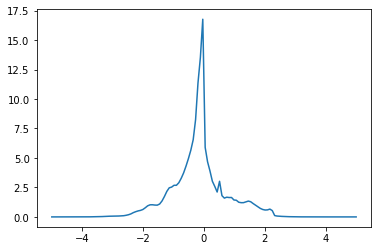

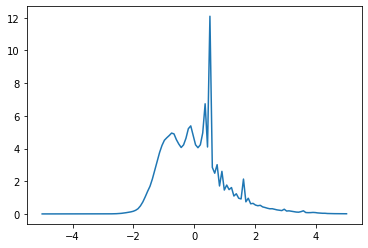

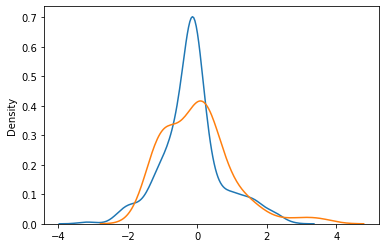

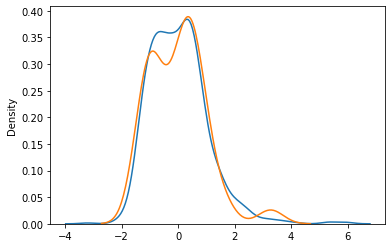

val loss 1.7021660804748535
step: 31, loss: 1.6838622093200684


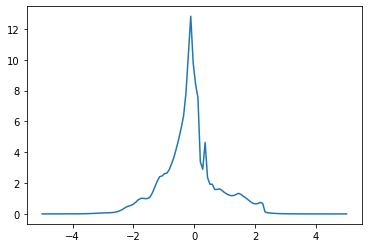

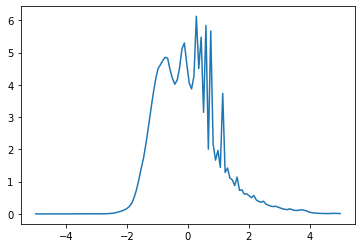

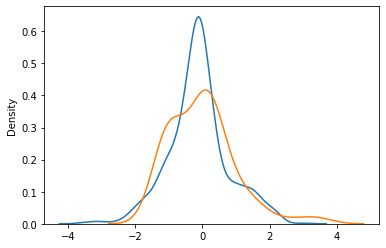

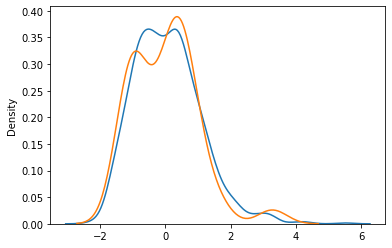

val loss 1.6838622093200684
step: 32, loss: 1.6523879766464233


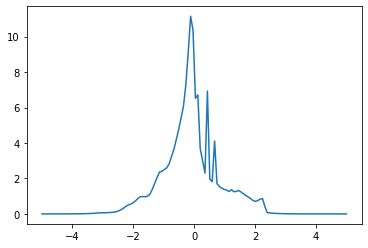

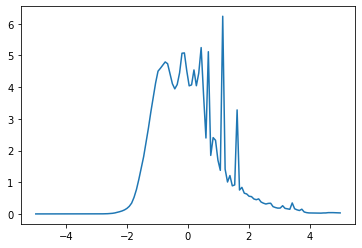

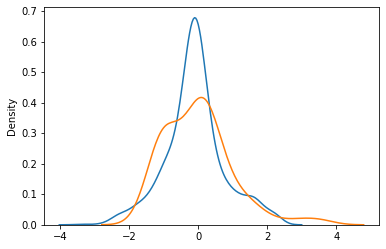

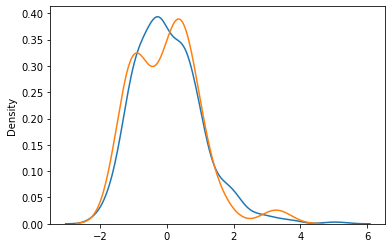

In [31]:
steps = 5000

best_val_loss = float('inf')
batch_size=1024
optimizer = torch.optim.Adam(trainable_parameters.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    randindex = torch.randint(0, 30000, (batch_size,))
#     batch = X[:, randindex, :]
    batch = X

    log_prob = flow_dist.log_prob(batch.view(-1, dim)).view(batch.shape[:-1])
    
    log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 1 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


        with torch.no_grad():
            if dim == 1:
                X = torch.linspace(-5, 5, 128)
                p = flow_dist.log_prob(X[:, None]).exp()
                plt.plot(X.numpy(), p.numpy())
                plt.show()
            else:
                linspace = torch.linspace(-5, 5, 128)
                grid = torch.meshgrid(linspace, linspace, indexing='xy')
                grid = torch.stack(grid).view(2, -1).permute(1, 0)
                p = flow_dist.log_prob(grid).exp().view(128, 128)
                plt.plot(linspace.numpy(), p.sum(0).numpy())
                plt.show()
                
                plt.plot(linspace.numpy(), p.sum(1).numpy())
                plt.show()
                
                samples = flow_dist.sample((1024,))
                sns.kdeplot(samples[:, 0].numpy())
                sns.kdeplot(X[:, :, 0].mean(1).numpy())
                plt.show()
                
                sns.kdeplot(samples[:, 1].numpy())
                sns.kdeplot(X[:, :, 1].mean(1).numpy())
                plt.show()


            log_prob_val = flow_dist.log_prob(X_val.view(-1, dim)).view(X_val.shape[:-1])

            log_prob_val = torch.logsumexp(log_prob_val, dim=-1) - math.log(log_prob_val.shape[-1])
            val_loss = -log_prob_val.mean()
            if val_loss > best_val_loss:
                break
            else:
                best_val_loss = val_loss
            print("val loss", loss.item())








In [32]:
import torch.nn.functional as F

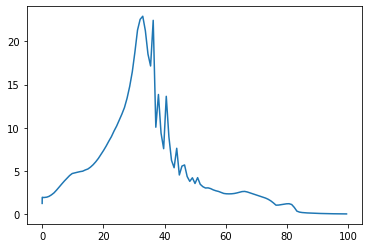

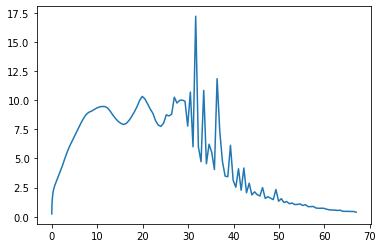

In [33]:
with torch.no_grad():   
        linspace = torch.linspace(-2, 3, 128)
        grid = torch.meshgrid(linspace, linspace, indexing='xy')
        grid = torch.stack(grid).view(2, -1).permute(1, 0)
        p = flow_dist.log_prob(grid).exp().view(128, 128)
        linspace_normalized = F.softplus(linspace[:, None] * std + mu).squeeze()
        plt.plot(linspace_normalized[:, 0], p.sum(0).numpy())
        plt.show()

        plt.plot(linspace_normalized[:, 1].numpy().squeeze(), p.sum(1).numpy())
        plt.show()

#         samples = flow_dist.sample((1024,))
#         sns.kdeplot(samples[:, 0].numpy())
#         sns.kdeplot(X[:, :, 0].mean(1).numpy())
#         plt.show()

#         sns.kdeplot(samples[:, 1].numpy())
#         sns.kdeplot(X[:, :, 1].mean(1).numpy())
#         plt.show()



In [34]:
linspace_normalized * std

tensor([[2.7691e-03, 6.3673e-03],
        [6.5050e-03, 1.1469e-02],
        [1.5279e-02, 2.0656e-02],
        [3.5880e-02, 3.7192e-02],
        [8.4200e-02, 6.6937e-02],
        [1.9730e-01, 1.2038e-01],
        [4.6071e-01, 2.1617e-01],
        [1.0672e+00, 3.8721e-01],
        [2.4288e+00, 6.9050e-01],
        [5.3269e+00, 1.2218e+00],
        [1.0915e+01, 2.1339e+00],
        [2.0190e+01, 3.6485e+00],
        [3.3149e+01, 6.0414e+00],
        [4.8792e+01, 9.5731e+00],
        [6.5966e+01, 1.4378e+01],
        [8.3893e+01, 2.0392e+01],
        [1.0216e+02, 2.7388e+01],
        [1.2058e+02, 3.5084e+01],
        [1.3906e+02, 4.3235e+01],
        [1.5757e+02, 5.1663e+01],
        [1.7609e+02, 6.0252e+01],
        [1.9462e+02, 6.8935e+01],
        [2.1315e+02, 7.7670e+01],
        [2.3168e+02, 8.6435e+01],
        [2.5021e+02, 9.5216e+01],
        [2.6874e+02, 1.0401e+02],
        [2.8727e+02, 1.1280e+02],
        [3.0580e+02, 1.2160e+02],
        [3.2433e+02, 1.3040e+02],
        [3.428